In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input

sns.set_theme()

In [2]:
import requests

# loading inflation data from drive

download_url = 'https://drive.google.com/uc?export=download&id=1yqfoFz98iY4CvrQt-rl2umN-uGB38r4X'
destination_path = '/content/1yqfoFz98iY4CvrQt-rl2umN-uGB38r4X'
# Send a GET request to download the file
response = requests.get(download_url)
response.raise_for_status()  # Raise an exception for HTTP errors
with open(destination_path, 'wb') as file:
   file.write(response.content)


inflation = pd.read_csv("/content/1yqfoFz98iY4CvrQt-rl2umN-uGB38r4X" )

In [18]:
y = inflation["Value"].values
y_test = y[337:]

Constructing the GAN model with a generator and a discriminator.

In [7]:
# Set random seed for TensorFlow
tf.random.set_seed(9)

### Defining generator model

def create_generator():
   model = Sequential([
      Input(shape = (12, )),
      Dense(120),
      LeakyReLU(alpha = 0.01),
      Dense(12, ),
      LeakyReLU(alpha = 0.3)
      ])
   return model

### Defining discriminator model
def create_discriminator():
  model = Sequential([
      Input(shape = (12, )),
      Dense(30, activation='relu'),
      Dense(1, activation='sigmoid')
  ])
  return model

Defining loss functions for the generator and discriminator networks training. Both of them are the cross-entropy loss functions.

In [8]:
def discr_loss(real_classified, fake_classified):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_classified), real_classified)
    fake_loss = cross_entropy(tf.zeros_like(fake_classified), fake_classified)
    return real_loss + fake_loss

def gen_loss(fake_classified):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_classified), fake_classified)


Defining training process for GAN.

In [9]:
def GAN_training_step(batch, generator, discriminator, seed):
  tf.random.set_seed(seed)
  noise = tf.random.normal([len(batch), 12])

  np.random.seed(seed)

  ### gradient update of generator and discriminator
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
     generated_series = generator(noise, training = True)
     real_classified = discriminator(batch, training=True)
     fake_classified = discriminator(generated_series, training=True)

     generator_loss = gen_loss(fake_classified)
     discriminator_loss = discr_loss(real_classified, fake_classified)

  generator_gradient = gen_tape.gradient(generator_loss, generator.trainable_variables)
  discriminator_gradient = discr_tape.gradient(discriminator_loss, discriminator.trainable_variables)

  discr_optimizer = tf.keras.optimizers.Adam(1e-3)
  gen_optimizer = tf.keras.optimizers.Adam(1e-3)

  gen_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
  discr_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))


def GAN_training(data, generator, discriminator, seed, batch_size = 30, epochs=100):

  for epoch in range(epochs):
     ### in each training epoch, a batch from data is ensembled
     np.random.seed(seed + epoch)
     batch_indeces = np.random.choice(range(len(data)), size = batch_size)
     batch = data[batch_indeces]
     GAN_training_step(batch, generator, discriminator, seed)

In [10]:
### creating the function that generates dataset for GAN training
def GAN_data_generator(W):
  data = []
  for k  in range(len(W)-11):
    data.append(W[k: k+12])
  return(data)

Forecasting with GAN. Due to high randomness in the optimization process of GAN training, it was not possible to create reproducible result for each time. Every time running the code yields a different forecast result, even when setting random seeds. For this reason, the GAN forecast used in the thesis is saved in a separate csv file: inflation_gan.csv.

In [14]:
y_gan = []

for k in range(18):
    W = y[301+k*12 : 337+k*12]

    # saving the mean of the past window for future comparison
    past_mean = np.mean(y[325+k*12 : 337+k*12])

    # in each forecast step, a new generator and discriminator are created
    generator = create_generator()
    discriminator = create_discriminator()

    data_GAN = np.array(GAN_data_generator(W))

    GAN_training(data_GAN, generator, discriminator, seed = k+1)

    ### creating a list to store the simulated values that are classified 1 by the discriminator
    simulated_values = []
    ### creating a list to store the simulated values that are classified 0 by the discriminator
    simulated_values_non_discriminated = []
    ### simulating 100 synthetic time series from the generator network
    for s in range(100):
        tf.random.set_seed(s*(k+1))
        noise = tf.random.normal([1, 12])

        simulated_series = np.array(generator(noise, training = False))[0]

        ### saving the simulated value that is classified with 1 by the discriminator
        if float(discriminator(np.array([list(simulated_series)]) , training=True)) > 0.5:

           simulated_values.append( simulated_series  )
        ### saving the simulated value that is classified with 0 by the discriminator
        else:
          simulated_values_non_discriminated.append(simulated_series)

    ### checking if the list of the simulated series with classification 1 is empty or not
    # if not empty, then selected the series with classification 1 that is closest to the past observations in terms of absolute mean
    if simulated_values != []:
        mean_difference = []
        for simulation in simulated_values:
            mean_difference.append(np.abs(past_mean - np.mean(simulation) ))

        prediction_12steps = simulated_values[np.argmin(mean_difference)]
    # if empty, then select the one from the saved series with classification 0
    else:
        mean_difference_non_discriminated = []
        for simulation in simulated_values_non_discriminated:
               mean_difference_non_discriminated.append(np.abs(past_mean - np.mean(simulation) ))

        prediction_12steps = simulated_values_non_discriminated[np.argmin(mean_difference_non_discriminated)]

    y_gan = y_gan + list(prediction_12steps)

y_gan = np.array(y_gan[:-1])

Plotting the forecast against the inflation.

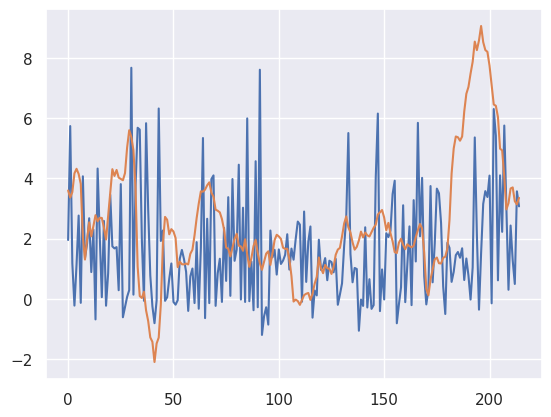

In [19]:
plt.plot(y_gan)
plt.plot(y_test)

As stated before, each time running the code does not give the same GAN forecast result. To reproduce the GAN forecast in the thesis report, please load the inflation_gan.csv file:

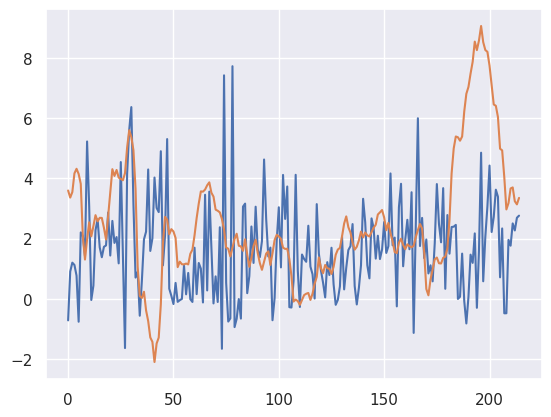

In [20]:
file_id =  '1BYl-7boBcVRZyL9oFZo3yLj4n8gAbaTE'
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'
destination_path = f'/content/{file_id}'
  # Send a GET request to download the file
response = requests.get(download_url)
response.raise_for_status()  # Raise an exception for HTTP errors
with open(destination_path, 'wb') as file:
    file.write(response.content)

y_gan_saved = pd.read_csv("/content/1BYl-7boBcVRZyL9oFZo3yLj4n8gAbaTE", header=None ).values
y_gan = y_gan_saved.reshape(1, -1)[0]

plt.plot(y_gan)
plt.plot(y_test)